In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [37]:
import requests
import datetime

def get_weather_history(city, start_date, end_date, api_key):
    url = "http://api.openweathermap.org/data/2.5/onecall/timemachine"
    lat, lon = 33.8366, -117.9143  # Coordinates for Anaheim, CA
    weather_data = []

    current_date = start_date
    while current_date <= end_date:
        timestamp = int(current_date.timestamp())
        response = requests.get(url, params={
            'lat': lat,
            'lon': lon,
            'dt': timestamp,
            'appid': api_key
        })
        data = response.json()
        weather_data.append(data)
        current_date += datetime.timedelta(days=1)

    return weather_data

# Example usage
api_key = '6083020f47eae51b553f6368050f7c68'
start_date = datetime.datetime(2025, 1, 1)
end_date = datetime.datetime(2025, 1, 2)
weather_history = get_weather_history('Anaheim', start_date, end_date, api_key)

print(weather_history)

[{'cod': 401, 'message': 'Invalid API key. Please see https://openweathermap.org/faq#error401 for more info.'}, {'cod': 401, 'message': 'Invalid API key. Please see https://openweathermap.org/faq#error401 for more info.'}]


In [38]:
# Replace with your actual Visual Crossing API key
API_KEY = 'R8TTA5U8TXFHXTN3REM8A4V5T'

# Fort Mason coordinates (San Francisco)
location = 'Fort Mason, San Francisco, CA'

# Date range for your sales data
start_date = '2019-01-01'
end_date = '2023-12-31'

# Build the API request URL
url = (
    f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
    f"{location}/{start_date}/{end_date}"
    f"?unitGroup=metric&include=days&key={API_KEY}&contentType=json"
)

# Make the request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    weather_data = response.json()

    # Parse daily weather data into DataFrame
    days = weather_data.get("days", [])
    weather_df = pd.DataFrame(days)

    # Convert date to datetime
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

    # Preview
    print(weather_df[['datetime', 'temp', 'humidity', 'precip', 'windspeed']].head())

    # Save to CSV (optional)
    weather_df.to_csv("fort_mason_weather_2019_2023.csv", index=False)
else:
    print(f"Error: Unable to fetch data, received status code {response.status_code}")

Error: Unable to fetch data, received status code 401


In [39]:

def get_meteo_weather_history(lat, lon, start_date, end_date):

    # API endpoint and parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
        "timezone": "America/Los_Angeles"
    }

    # Make the request
    response = requests.get(url, params=params)
    data = response.json()

    # Convert to DataFrame
    weather_df = pd.DataFrame({
        "date": data["daily"]["time"],
        "temp_max": data["daily"]["temperature_2m_max"],
        "temp_min": data["daily"]["temperature_2m_min"],
        "precipitation": data["daily"]["precipitation_sum"]
    })

    # Convert date to datetime object
    weather_df["date"] = pd.to_datetime(weather_df["date"])


    return weather_df

# Example usage
# Fort Mason coordinates (approximate)
#latitude = 37.8058
#longitude = -122.4301

# Date range (based on your dataset)
start_date = "2019-01-01"
end_date = "2024-12-31"




Get the weather for Fort Mason Equator Coffe (don't do this over and over - this uses a free open source api which asks its users to respect the usage)
Save it to a CSV
Turns out we only need to do Fort Mason as the other two coffee shops are close by

In [40]:
# Fort Mason - Equator Coffee lat lon
fortMasonLatitude = 37.805424841127625
fortMasonLongitude = -122.43189815767089
# only run this if we lose our data and need to pull it again (uses a free api)
if (False):
    weather_df = get_meteo_weather_history(fortMasonLatitude, fortMasonLongitude, start_date, end_date)
    # Save to CSV
    weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv", index=False)
else:
    #weather_df = pd.read_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv")
    weatherURL = "https://www.dropbox.com/scl/fi/khb765ddg0qox6iy8qtkb/sanfran_weather.csv?rlkey=yccip6qd8kcx0jqz80jocddqf&dl=1"
    weather_data = pd.read_csv(weatherURL)


# Preview
print(weather_data.head())


# # Lake Merrit - Equator Coffee lat lon  - DON'T BOTHER - LAT LON IS NEARLY THE SAME AS FORT MASON
# lakeMerritLatitude = 37.81242756270673
# lakeMerritongitude = -122.26105919815194
# weather_df = get_meteo_weather_history(lakeMerritLatitude, lakeMerritongitude, start_date, end_date)
# # Save to CSV
# weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\lake_merrit_open_meteo_weather.csv", index=False)


         date  temp_max  temp_min  precipitation
0  2019-01-01      12.1       4.2            0.0
1  2019-01-02      11.6       4.5            0.0
2  2019-01-03      10.9       4.6            0.0
3  2019-01-04      12.0       4.9            0.0
4  2019-01-05      12.7       9.4            5.8


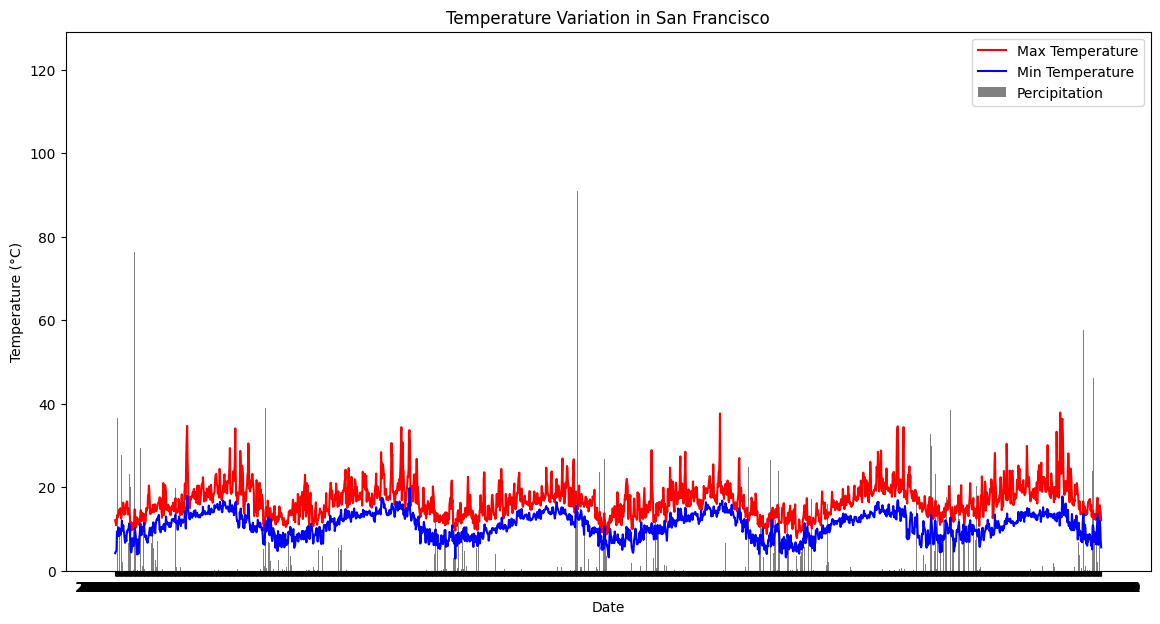

In [41]:
# Graph the weather data
plt.figure(figsize=(14, 7)) 
plt.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red')
plt.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='blue')
# Show percipitation as a bar chart
plt.bar(weather_data['date'], weather_data['precipitation'], label='Percipitation', color='gray')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation in San Francisco')
plt.legend()
plt.show()


In [42]:
#import pandas as pd

# Replace 'your_file_path.csv' with the actual path to your CSV file
file_path = 'C:\Dev\School\SFU\Courses\Bus774-AIforBusiness\GroupProject\Group4data\Fort Mason 5yr Net Sales by Day (MSD and SD) 20250321 110018.csv'
df = pd.read_csv(file_path)

# Display the first 10 items
print(df.head(10))

   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
1            6    Fort Mason  1/1/2019     Tuesday             FOOD   
2            6    Fort Mason  1/1/2019     Tuesday             FOOD   
3            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
4            6    Fort Mason  1/1/2019     Tuesday           RETAIL   
5            6    Fort Mason  1/1/2019     Tuesday             FOOD   
6            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
7            6    Fort Mason  1/1/2019     Tuesday             FOOD   
8            6    Fort Mason  1/1/2019     Tuesday             FOOD   
9            6    Fort Mason  1/1/2019     Tuesday      BEER & WINE   

                          SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0       Retail Coffee Drinks  1908.65        17.75             0  
1         Baked Goods-Pantry   199.75         0.00             0  
2     Retail Pack

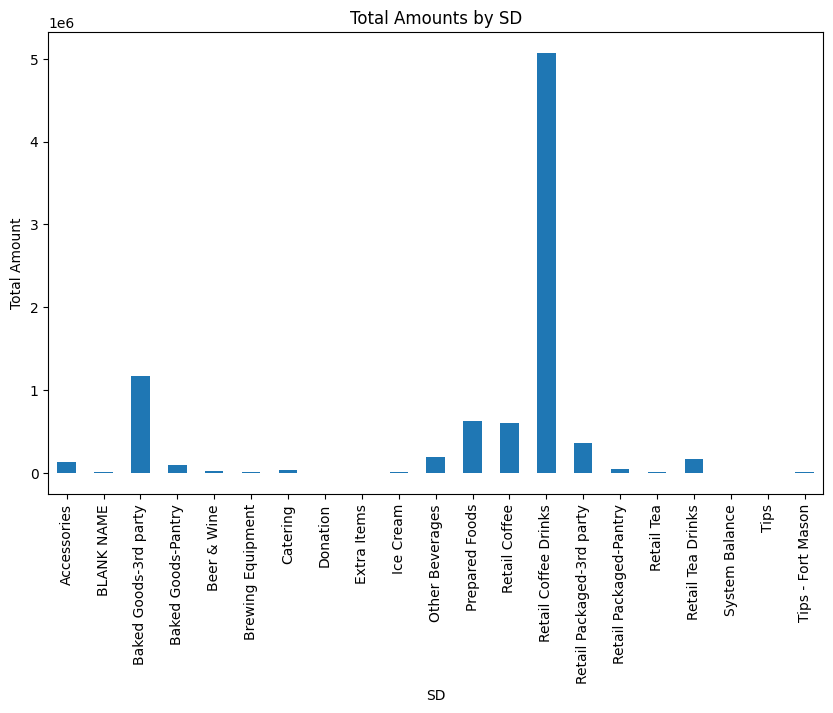

In [43]:
import matplotlib.pyplot as plt

# Group the data by 'SD' and sum the 'AMOUNT'
grouped_data = df.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar')
plt.title('Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

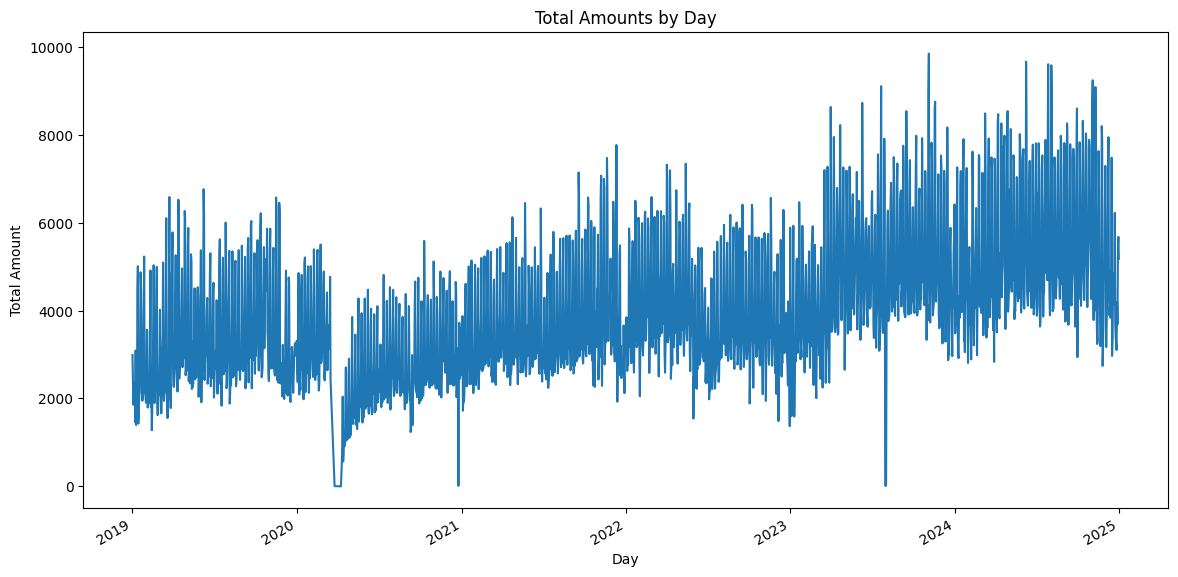

In [44]:
# Convert 'DOB' to datetime
df['DOB'] = pd.to_datetime(df['DOB'])

# Group the data by 'DOB' and sum the 'AMOUNT'
daily_totals = df.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
daily_totals.plot(kind='line')
plt.title('Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()

In [45]:
zero_sales_days = daily_totals[daily_totals < 750]
print(zero_sales_days)

DOB
2020-03-25      4.25
2020-04-08      0.00
2020-04-10    515.63
2020-04-13    565.75
2020-12-25     11.00
2023-07-31     40.00
2023-08-01      7.25
2023-08-02     42.00
Name: AMOUNT, dtype: float64


c:\Python311\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x0000024A93575C10>.

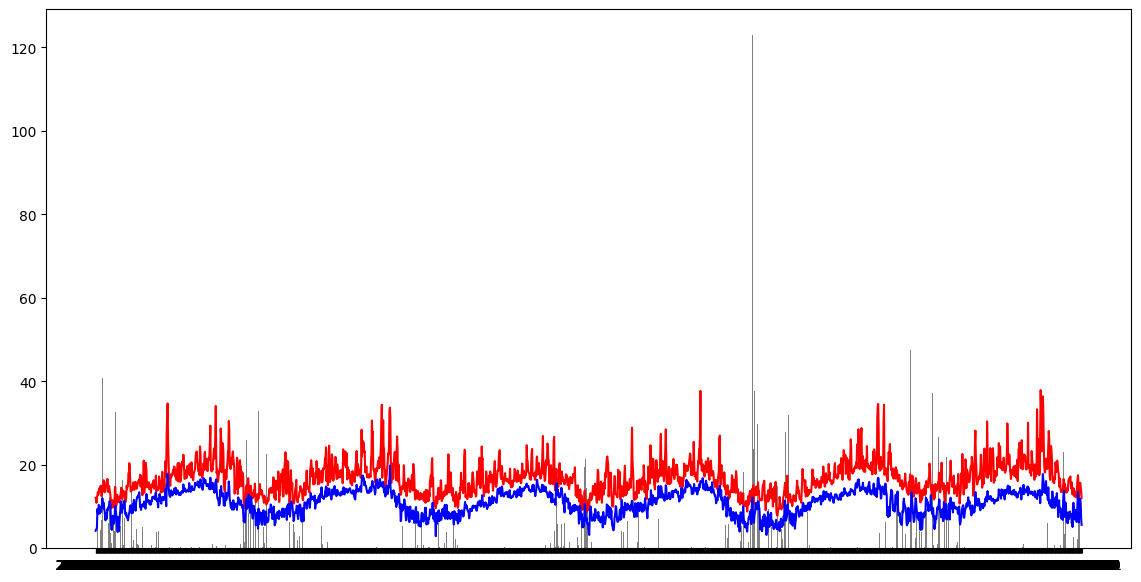

In [47]:
# # Convert 'DOB' to datetime
# df['DOB'] = pd.to_datetime(df['DOB'])

# Group the data by 'DOB' and sum the 'AMOUNT'
daily_totals = df.groupby('DOB')['AMOUNT'].sum()

# # Plot the data
# plt.figure(figsize=(14, 7))
# daily_totals.plot(kind='line')
# # plt.title('Total Amounts by Day')
# # plt.xlabel('Day')
# # plt.ylabel('Total Amount')


# Graph the weather data
plt.figure(figsize=(14, 7)) 
plt.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red')
plt.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='blue')
# Show percipitation as a bar chart
plt.bar(weather_data['date'], weather_data['precipitation'], label='Percipitation', color='gray')
# Show sales data as a line chart
daily_totals.plot(kind='line', label='Total Sales', color='green')

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation in San Francisco')
plt.legend()



plt.show()

In [ ]:
# Convert 'DOB' to datetime if not already done
df['DOB'] = pd.to_datetime(df['DOB'])

# Group the data by 'DOB' and sum the 'AMOUNT'
daily_totals = df.groupby('DOB')['AMOUNT'].sum()

# Plot the sales data
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Amount', color=color)
ax1.plot(daily_totals.index, daily_totals.values, color=color, label='Total Amount')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot the weather data
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', color=color)
ax2.plot(weather_data['date'], weather_data['temp_max'], color='red', label='Max Temperature')
ax2.plot(weather_data['date'], weather_data['temp_min'], color='blue', label='Min Temperature')
ax2.tick_params(axis='y', labelcolor=color)

# Show precipitation as a bar chart on the second y-axis
ax2.bar(weather_data['date'], weather_data['precipitation'], label='Precipitation', color='gray', alpha=0.3)

fig.tight_layout()  # Adjust layout to make room for both y-axes
plt.title('Sales and Weather Data Overlay')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()